In [1]:
import scipy
from math import sqrt
from scipy import stats
from numpy import cov, linspace
from statistics import mean
from numpy.random import normal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N):
    A_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    B_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    A_after  = [x + normal(loc=0, scale=eps_sigma) for x in A_before]
    B_after  = [x + normal(loc=0, scale=eps_sigma) + treatment_lift for x in B_before]
    return A_before, B_before, A_after, B_after

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    mean_before = mean(A_before + B_before)
    A_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
    lr = stats.linregress(A_before + B_before, A_after + B_after)
    mean_after = mean(A_after + B_after)
    A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
    B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def lift(A, B):
    return mean(B) - mean(A)

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (sqrt(cv[0, 0]) * sqrt(cv[1, 1]))
    return 1 - corr**2

def p_value(A, B):
    return stats.ttest_ind(A, B)[1]

A mean before = 099.9, A mean after = 100.9, A mean after adjusted = 103.3
B mean before = 104.7, B mean after = 106.2, B mean after adjusted = 103.8
Traditional    A/B test evaluation, lift = 5.350, p-value = 0.028
CUPED adjusted A/B test evaluation, lift = 0.531, p-value = 0.550


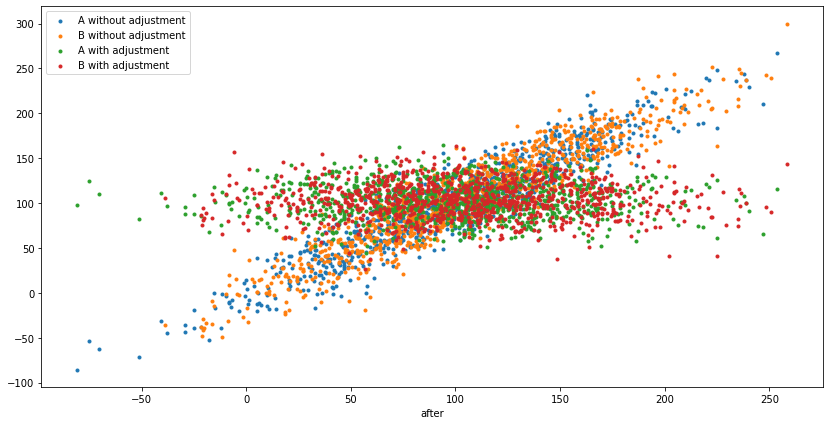

In [3]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 2

A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)

print('A mean before = %05.1f, A mean after = %05.1f, A mean after adjusted = %05.1f' % (mean(A_before), mean(A_after), mean(A_after_adjusted)))
print('B mean before = %05.1f, B mean after = %05.1f, B mean after adjusted = %05.1f' % (mean(B_before), mean(B_after), mean(B_after_adjusted)))
print('Traditional    A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after, B_after), p_value(A_after, B_after)))
print('CUPED adjusted A/B test evaluation, lift = %.3f, p-value = %.3f' % (lift(A_after_adjusted, B_after_adjusted), p_value(A_after_adjusted, B_after_adjusted)))

plt.figure(figsize=(14, 7))
plt.scatter(A_before, A_after, marker='.')
plt.scatter(B_before, B_after, marker='.')
plt.scatter(A_before, A_after_adjusted, marker='.')
plt.scatter(B_before, B_after_adjusted, marker='.')
plt.xlabel('before')
plt.xlabel('after')
plt.legend(['A without adjustment', 'B without adjustment', 'A with adjustment', 'B with adjustment'])
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 2.13, variance of lift = 6.15
CUPED adjusted A/B testing, mean lift = 1.96, variance of lift = 0.88
CUPED lift variance / tradititional lift variance = 0.14 (expected = 0.14)


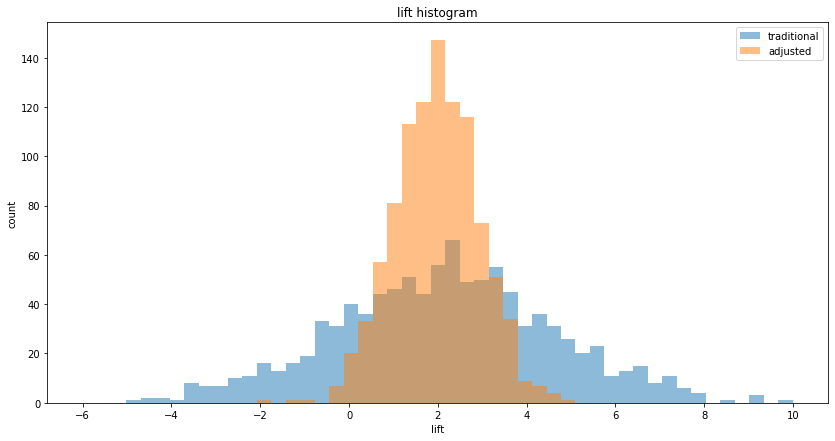

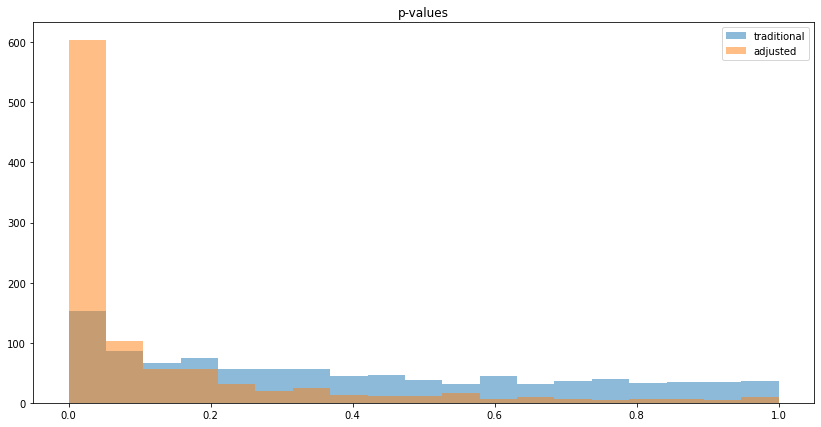

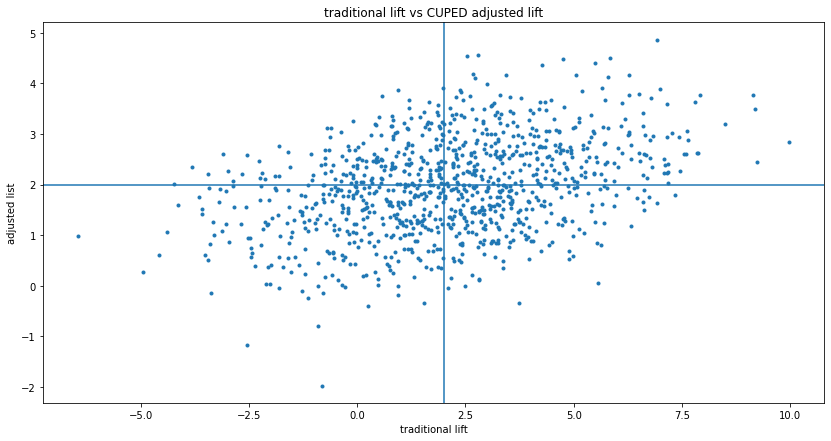

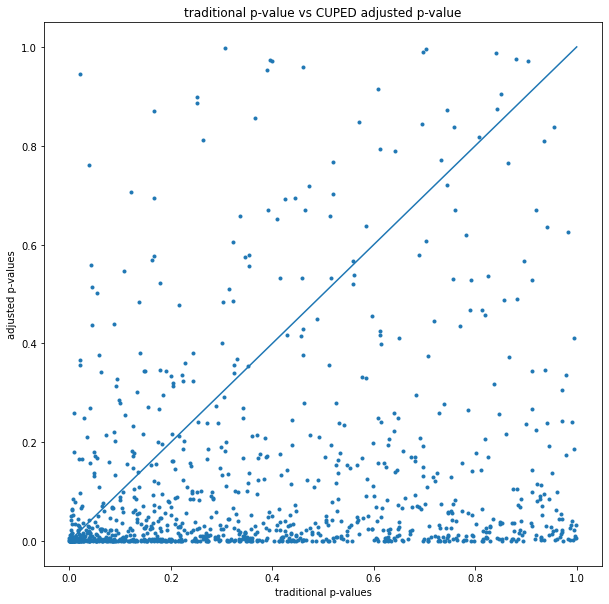

In [4]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))

large_N = 1000*1000
A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 1.93, variance of lift = 4.92
CUPED adjusted A/B testing, mean lift = 1.93, variance of lift = 4.91
CUPED lift variance / tradititional lift variance = 1.00


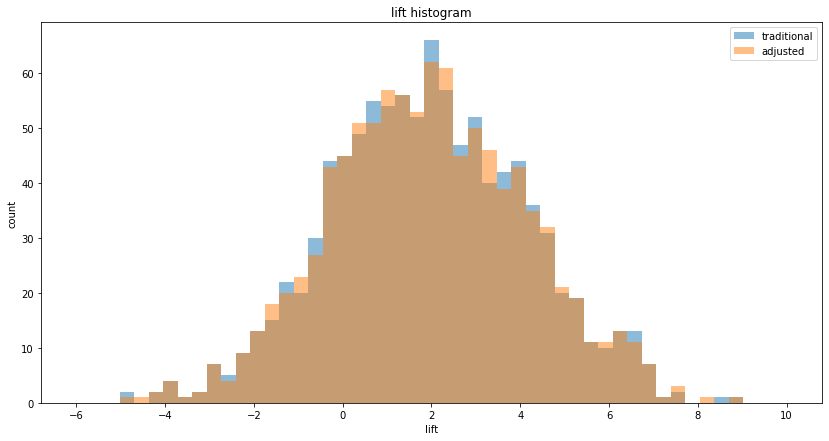

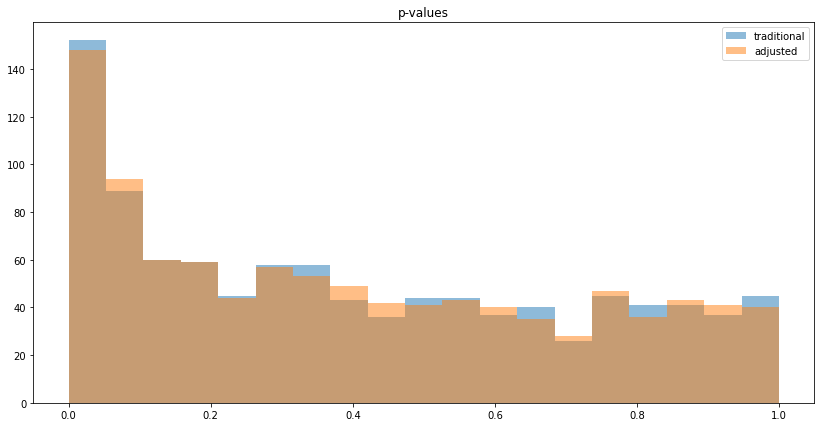

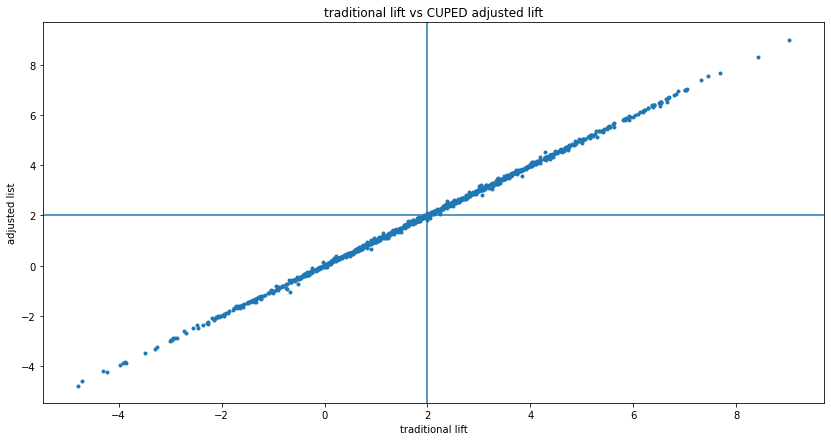

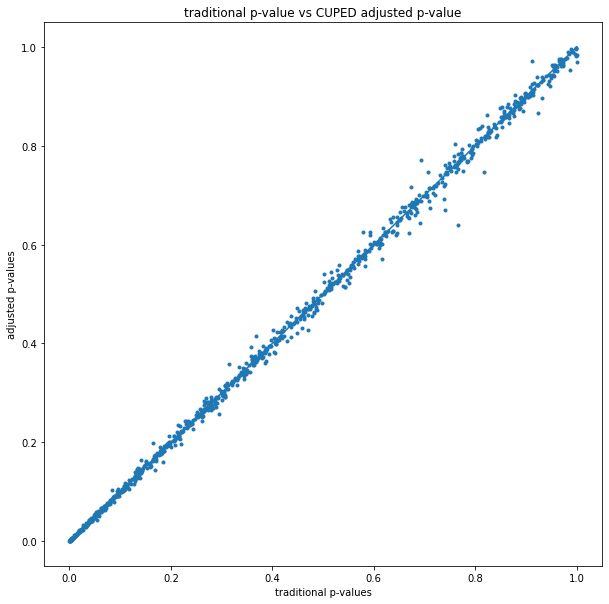

In [5]:
### no correlation

def get_AB_samples_nocorr(mu, sigma, treatment_lift, N):
    A_before = list(normal(loc=mu, scale=sigma, size=N))
    B_before = list(normal(loc=mu, scale=sigma, size=N))
    A_after  = list(normal(loc=mu, scale=sigma, size=N))
    B_after  = list(treatment_lift + normal(loc=mu, scale=sigma, size=N))
    return A_before, B_before, A_after, B_after

N = 1000
mu = 100 
sigma = 50
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(mu, sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))
print('CUPED lift variance / tradititional lift variance = %.2f' % (cov(adjusted_lifts)/cov(traditional_lifts)))

# large_N = 1000*1000
# A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
# elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
# print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()